In [1]:

import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

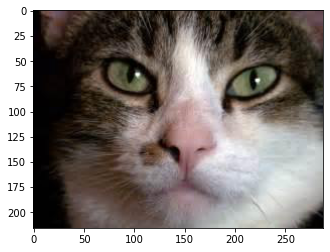

In [2]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')


imshow(np.asarray(pil_im))

In [3]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/kaggle/input/animalsdataset/dataset/training'
validation_data_dir = '/kaggle/input/animalsdataset/dataset/validation'
test_data_dir = '/kaggle/input/animalsdataset/dataset/test'
image_size = (150, 150)
batch_size = 512

In [4]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 21068 files belonging to 10 classes.
Found 6634 files belonging to 10 classes.
Found 3418 files belonging to 10 classes.


# **Image Augmentation**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    #validation_split=0.2,
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds_augmentation = validation_datagen.flow_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 21068 images belonging to 10 classes.
Found 0 images belonging to 10 classes.


# **The Model**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling

#MODEL --------------------------------------------------
model = Sequential()
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

model.add(Conv2D(8, kernel_size=(3, 3), activation='relu')) 

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3))

model.add(Conv2D(32, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3))

model.add(Flatten()) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.7))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 16)      1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0

In [7]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [8]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 160

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

history = model.fit(
          train_ds_augmentation,
          epochs=epochs,
          validation_data = validation_ds_augmentation,
          callbacks = [es]
)


Epoch 1/160
42/42 [==============================] - 214s 5s/step - loss: 2.2234 - accuracy: 0.1894
Epoch 2/160
42/42 [==============================] - 147s 3s/step - loss: 2.2075 - accuracy: 0.2031
Epoch 3/160
42/42 [==============================] - 147s 3s/step - loss: 2.2060 - accuracy: 0.2035
Epoch 4/160
42/42 [==============================] - 147s 3s/step - loss: 2.2040 - accuracy: 0.2038
Epoch 5/160
42/42 [==============================] - 146s 3s/step - loss: 2.2023 - accuracy: 0.2041
Epoch 6/160
 8/42 [====>.........................] - ETA: 1:45 - loss: 2.2043 - accuracy: 0.2005

KeyboardInterrupt: 

In [ ]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

In [ ]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Reconocimiento Animales')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

In [ ]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline

pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






In [ ]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")